# Observational Datasets

In [1]:
import os
import copy

import math
import xarray as xr
import pandas as pd
import numpy as np
import dask
import glob

from dask_jobqueue import PBSCluster
from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## PBS Cluster Setup

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    project='P93300041',                         # Input your project ID here
    walltime='04:00:00',                         # Amount of wall time
    interface='ext',                             # Interface to use
)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33565 instead
  warnings.warn(


In [3]:
cluster.scale(10)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
client = Client(cluster)

## Helper Functions

In [5]:
def adjust_lon(ds, lon_name):

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (
        ds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
        .drop_vars(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})

    return ds

In [6]:
def get_surdat(surdat_file):

    surdat = xr.open_dataset(surdat_file)

    # set actual latitude and longitude values as the dimension values
    surdat['lat'] = xr.DataArray(np.unique(surdat.LATIXY.values), dims='lsmlat')
    surdat['lon'] = xr.DataArray(np.unique(surdat.LONGXY.values), dims='lsmlon')
    surdat = surdat.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

    surdat['PCT_NAT_PFT_UPDATED'] = (surdat.PCT_NAT_PFT*(surdat.PCT_NATVEG/100.0))
    surdat['PCT_CFT_UPDATED'] = (surdat.PCT_CFT*(surdat.PCT_CROP/100.0))

    out = surdat[['PCT_NAT_PFT_UPDATED', 'PCT_CFT_UPDATED']]

    return out

In [7]:
def plot_biome(biome_ds):
    biome_names = ['Ice sheet', 'Tropical rain forest',
                   'Tropical seasonal forest/savanna', 'Subtropical desert',
                   'Temperate rain forest', 'Temperate seasonal forest',
                   'Woodland/shrubland', 'Temperate grassland/desert',
                   'Boreal forest', 'Tundra']
    colors = ["#ADADC9", "#317A22", "#A09700", "#DCBB50", "#75A95E", "#97B669",
              "#D16E3F", "#FCD57A", "#A5C790", "#C1E1DD"]
    
    cmap = matplotlib.colors.ListedColormap(colors)
    
    fig, ax = plt.subplots(figsize=(13, 6),
                           subplot_kw=dict(projection=ccrs.Robinson()))
    
    ax.set_title('Whittaker Biomes', loc='left', fontsize='large', fontweight='bold')
    
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
    
    pcm = ax.pcolormesh(biome_ds.lon, biome_ds.lat, biome_ds.biome,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=-0.5,
                        vmax=9.5)
    
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.03,
                        orientation='vertical')
    cbar.set_label('Biome', size=12, fontweight='bold')
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cbar.set_ticklabels(biome_names)

In [8]:
def get_dom_pft_landmask(surdat, pft_indices, dominance_threshold):

    # subset surface data by pft
    # we allow more than one so that we can combine pfts (for FATES - CLM compatibility)
    pft_dat = surdat.where(surdat.natpft.isin(pft_indices))

    combined = pft_dat.PCT_NAT_PFT_UPDATED.sum(dim='natpft').to_dataset(name="PCT_NAT_PFT_UPDATED")

    dom_pft = combined.where(combined.PCT_NAT_PFT_UPDATED > dominance_threshold)

    # get number of gridcells
    cells = dom_pft.PCT_NAT_PFT_UPDATED.values
    num_gridcells = len(cells[~np.isnan(cells)])

    # create the landmask
    dom_pft['landmask'] = xr.where(~np.isnan(dom_pft.PCT_NAT_PFT_UPDATED), 1.0, 0.0)
    dom_pft['mod_lnd_props'] = dom_pft.landmask
    dom_pft['biome'] = surdat.biome

    return num_gridcells, dom_pft

In [9]:
def get_by_lat(global_dat, var, models, units, cf=None):

    if cf is not None:
        globd = (global_dat[var])*global_dat.land_area*cf
        globd = globd.where(globd.model.isin(models), drop = True)
        by_lat = globd.sum(dim='lon')
    else:
        globd = global_dat[var]
        globd = globd.where(globd.model.isin(models), drop = True)
        by_lat = globd.mean(dim='lon')

    by_lat.attrs = {'units': units, 'long_name': global_dat[var].attrs['long_name']}
    return globd, by_lat

In [10]:
def get_dataset(top_dir, models, var):
    
    data_sets = []
    for model in models:
        file_name = os.path.join(top_dir, f"{model}_{var}_regridded.nc")
        data_sets.append(xr.open_dataset(file_name))
    obs = xr.concat(data_sets, 'model', data_vars='all')
    obs = obs.assign_coords(model=("model", models))
 
    return obs

In [11]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier
def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

In [12]:
def plot_lat(data_bylat, var, varname, units):

    df = pd.DataFrame({'lat': np.tile(data_bylat.lat, len(data_bylat.model)),
                       'model': np.repeat(data_bylat.model, len(data_bylat.lat)),
                       var: data_bylat.values.flatten()})

    minvar = truncate(df[var].min())
    maxvar = round_up(df[var].max())
    meanval = df[var].values.mean()

    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
    for i in range(len(tableau20)):
        r, g, b = tableau20[i]
        tableau20[i] = (r/255., g/255., b/255.)

    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    plt.xlim(minvar, maxvar)
    plt.ylim(-90, 90)

    plt.yticks(range(-90, 91, 15), [str(x) + "º" for x in range(-90, 91, 15)],
               fontsize=10)
    plt.xticks(fontsize=10)

    for y in range(-90, 91, 15):
        plt.plot(range(math.floor(minvar), math.ceil(maxvar) + 1),
                 [y] * len(range(math.floor(minvar), math.ceil(maxvar) + 1)),
                 "--", lw=0.5, color="black", alpha=0.3)

    plt.tick_params(bottom=False, top=False, left=False, right=False)

    models = np.unique(df.model.values)
    for rank, model in enumerate(models):
        data = df[df.model == model]
        plt.plot(data[var].values, data.lat.values, lw=2, color=tableau20[rank],
                 label=model)

    plt.ylabel('Latitude (º)', fontsize=11)
    plt.xlabel(f'Annual {varname} ({units})', fontsize=11)
    plt.title(f"Observed Annual {varname}" + 
              " by latitude for different data products", fontsize=11)
    plt.legend(loc='upper right')

In [13]:
def choose_subplot_dimensions(k):
    if k < 2:
        return k, 1
    elif k < 11:
        return math.ceil(k/2), 2
    else:
        # I've chosen to have a maximum of 3 columns
        return math.ceil(k/3), 3

In [14]:
def generate_subplots(k, row_wise=False):
    nrow, ncol = choose_subplot_dimensions(k)
    figure, axes = plt.subplots(nrow, ncol, figsize=(13, 6),
                                subplot_kw=dict(projection=ccrs.Robinson()))
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)
            # Turn ticks on for the last ax in each column, wherever it lands
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)
        axes = axes[:k]
        return figure, axes

In [15]:
def plot_global(var_glob, var, varname, units, cmap, row_wise=False):

    vmin = var_glob.min().values
    vmax = var_glob.max().values
    models = var_glob.model.values
    n = len(models)
    figure, axes = generate_subplots(n, row_wise=False)
    if n > 1:
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        for idx, ax in enumerate(axes):
            dat = var_glob.sel(model=models[idx])
            pcm = map_function(ax, dat, models[idx], cmap, vmax, vmin=vmin)
        cbar = figure.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.5, orientation='horizontal')
    else:
        dat = var_glob.sel(model=models[0])
        pcm = map_function(axes[0], dat, models[0], cmap, vmax, vmin=vmin)
        cbar = figure.colorbar(pcm, ax=axes[0], shrink=0.5, orientation='horizontal')
    cbar.set_label(f'{varname} ({units})', size=10, fontweight='bold')

In [16]:
def map_function(ax, dat, title, cmap, vmax, vmin=0):
    ax.set_title(title, loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
    pcm = ax.pcolormesh(dat.lon, dat.lat, dat,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=vmin, vmax=vmax)
    return pcm

## Observations

In [17]:
top_dir = "/glade/work/afoster/FATES_calibration/ILAMB_data/regridded"

In [18]:
gpp_models = ['FLUXCOM', 'WECANN', 'GBAF']
lai_models = ['AVHRR', 'AVH15C1']
ef_models = ['FLUXCOM', 'CLASS', 'WECANN', 'GBAF']
et_models = ['FLUXCOM', 'DOLCE', 'CLASS', 'WECANN', 'GBAF']
mrro_models = ['LORA', 'CLASS']
sh_models = ['FLUXCOM', 'CLASS', 'WECANN', 'GBAF']
sw_models = ['WangMao']
albedo_models = ['CERES', 'GEWEX']
fsr_models = ['CERES', 'GEWEX']
fsa_models = ['CERES', 'GEWEX']
fire_models = ['CERES', 'GEWEX']
rlns_models = ['CERES', 'GEWEX']
rn_models = ['CERES', 'GEWEX', 'CLASS']
gr_models = ['CLASS']

In [19]:
gpp_obs = get_dataset(top_dir, gpp_models, 'GPP')
lai_obs = get_dataset(top_dir, lai_models, 'LAI')
ef_obs = get_dataset(top_dir, ef_models, 'EF')
et_obs = get_dataset(top_dir, et_models, 'ET')
mrro_obs = get_dataset(top_dir, mrro_models, 'MRRO')
sh_obs = get_dataset(top_dir, sh_models, 'SH')
sw_obs = get_dataset(top_dir, sw_models, 'SW')
albedo_obs = get_dataset(top_dir, albedo_models, 'albedo')
fsr_obs = get_dataset(top_dir, fsr_models, 'FSR')
fsa_obs = get_dataset(top_dir, fsa_models, 'FSA')
fire_obs = get_dataset(top_dir, fire_models, 'FIRE')
rlns_obs = get_dataset(top_dir, rlns_models, 'RLNS')
rn_obs = get_dataset(top_dir, rn_models, 'RN')
gr_obs = get_dataset(top_dir, gr_models, 'GR')

In [20]:
ds_sp = xr.open_dataset('/glade/campaign/cgd/tss/people/oleson/PPE/' +
                        'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1' +
                        '_nocrop_PPE2_hist/lnd/hist/' +
                        'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_' +
                        'nocrop_PPE2_hist.clm2.h0.2014-12.nc')
land_area = ds_sp.landfrac*ds_sp.area
land_area = land_area.to_dataset(name='land_area')
land_area['land_area'].attrs['units'] = 'km2'

In [22]:
global_dat = xr.merge([gpp_obs, lai_obs, ef_obs, et_obs, mrro_obs, sh_obs,
                       sw_obs, albedo_obs, fsr_obs, fsa_obs, fire_obs, 
                       rlns_obs, rn_obs, gr_obs, land_area])
global_dat.to_netcdf('../observations/ILAMB_global_obs.nc')

## Plotting

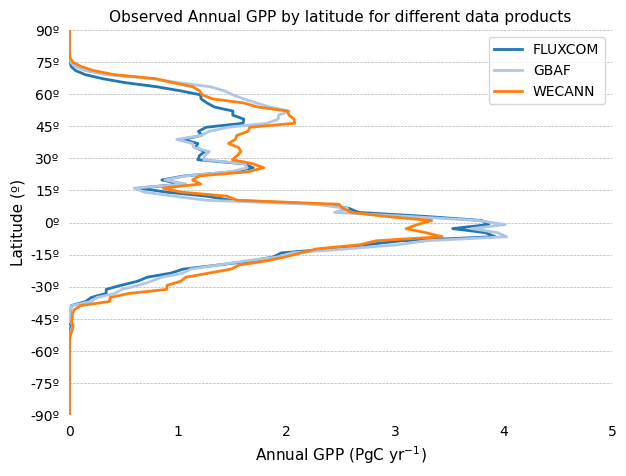

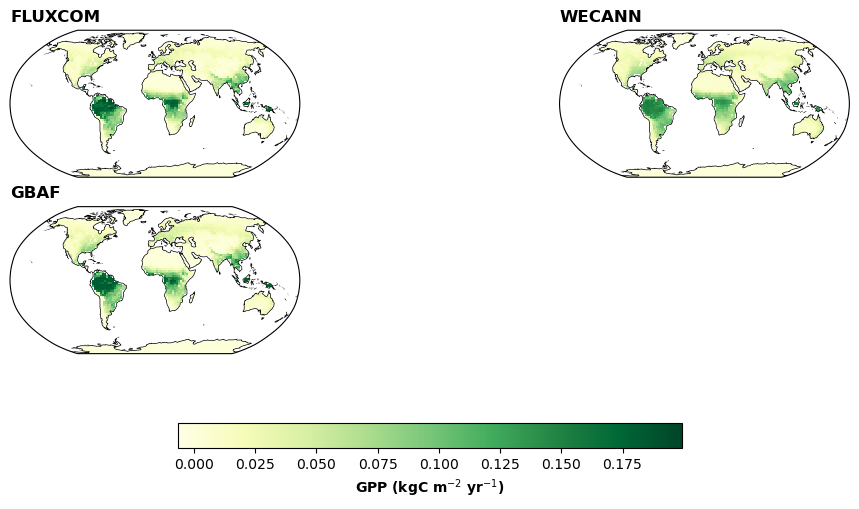

In [23]:
gpp_glob, gpp_bylat = get_by_lat(global_dat, 'gpp', gpp_models, 'PgC yr-1', 1e6*1e-12)
plot_lat(gpp_bylat, 'gpp', 'GPP', 'PgC yr$^{-1}$')
plot_global(gpp_glob, 'gpp', 'GPP', 'kgC m$^{-2}$ yr$^{-1}$', 'YlGn')

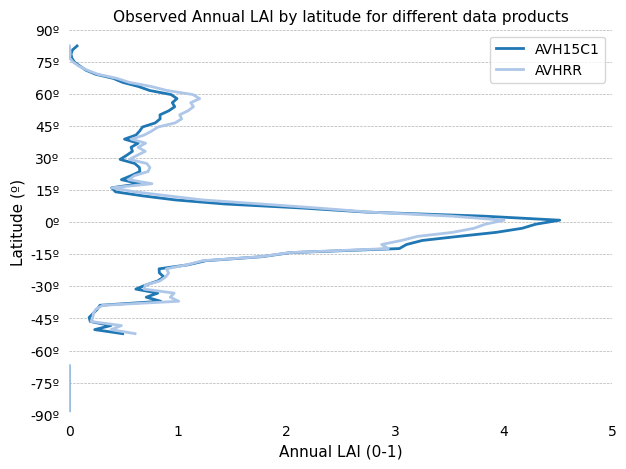

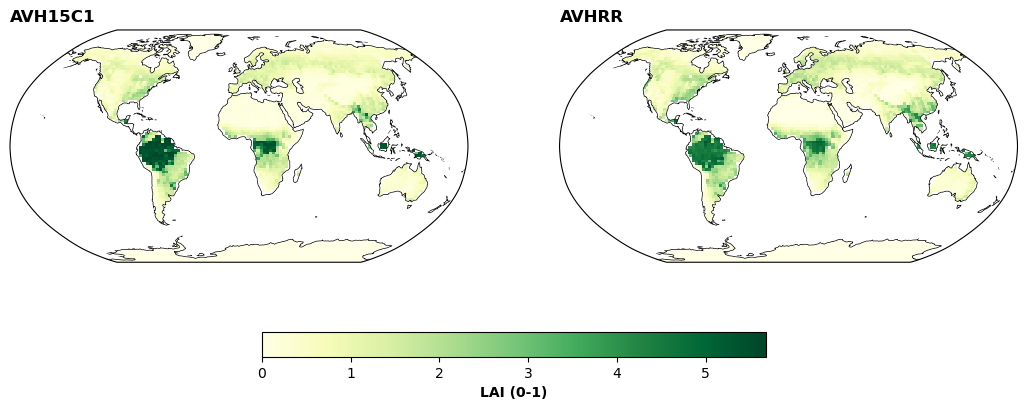

In [83]:
lai_glob, lai_bylat = get_by_lat(global_dat, 'lai', lai_models, '')
plot_lat(lai_bylat, 'lai', 'LAI', '0-1')
plot_global(lai_glob, 'lai', 'LAI', '0-1', 'YlGn')

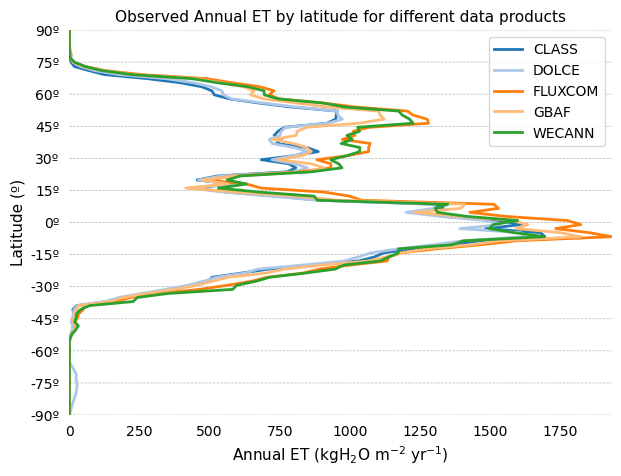

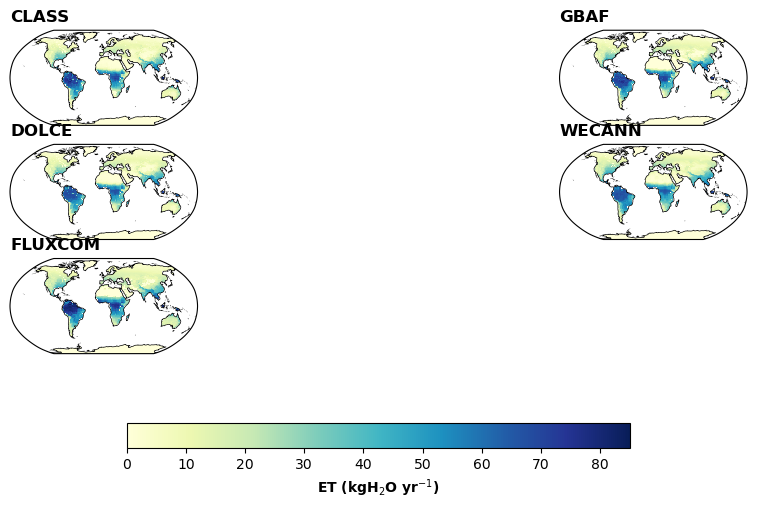

In [84]:
et_glob, et_bylat = get_by_lat(global_dat, 'et', et_models, 'PgH2O yr-1', 1e6*1e-12)
plot_lat(et_bylat, 'et', 'ET', 'kgH$_2$O m$^{-2}$ yr$^{-1}$')
plot_global(et_glob, 'et', 'ET', 'kgH$_2$O yr$^{-1}$', 'YlGnBu')

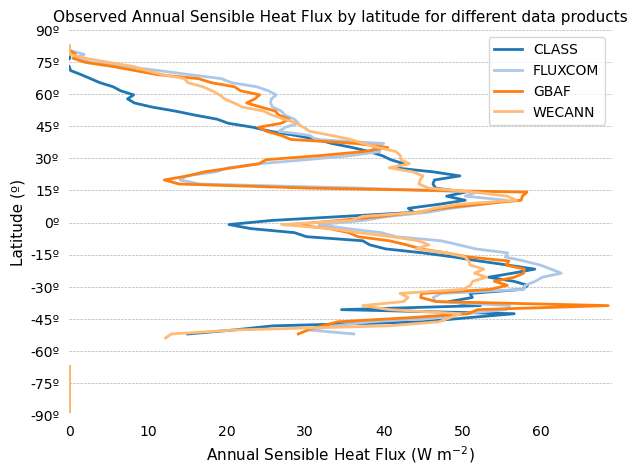

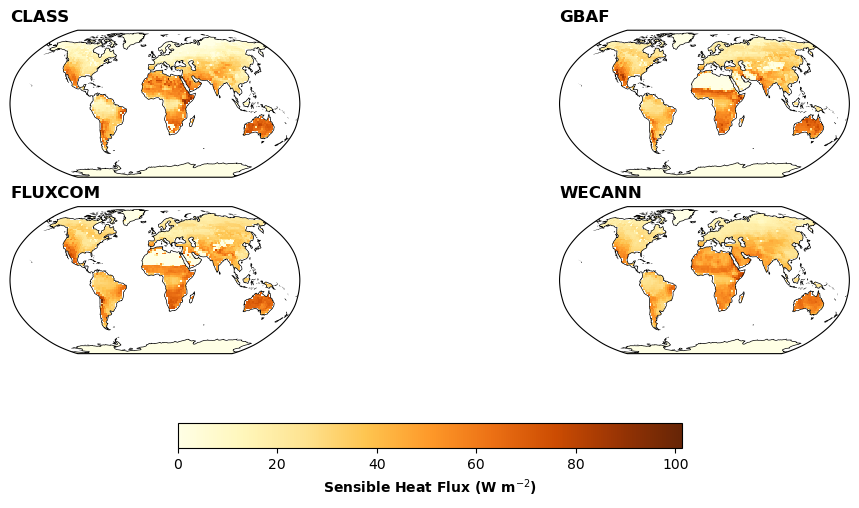

In [85]:
sh_glob, sh_bylat = get_by_lat(global_dat, 'sh', sh_models, 'W m-2')
plot_lat(sh_bylat, 'sh', 'Sensible Heat Flux', 'W m$^{-2}$')
plot_global(sh_glob, 'sh', 'Sensible Heat Flux', 'W m$^{-2}$', 'YlOrBr')

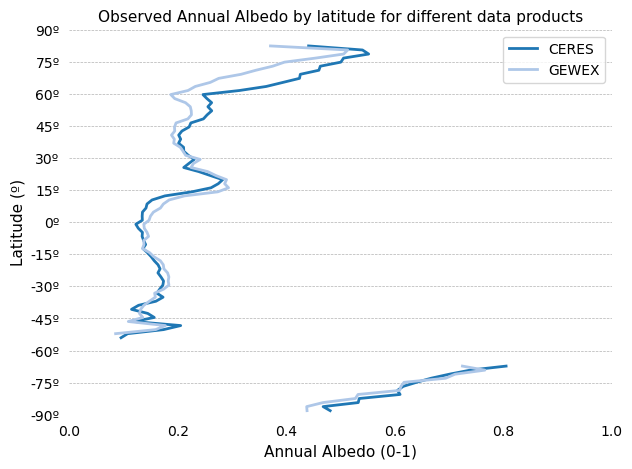

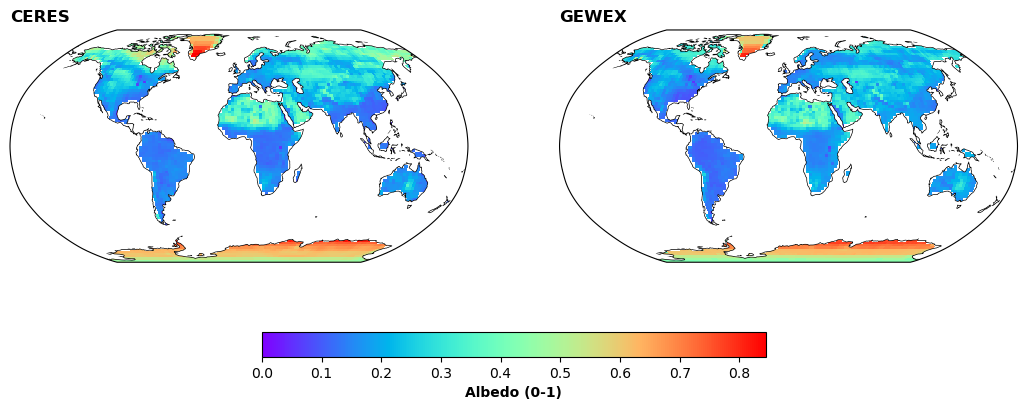

In [86]:
alb_glob, alb_bylat = get_by_lat(global_dat, 'albedo', albedo_models, '')
plot_lat(alb_bylat, 'albedo', 'Albedo', '0-1')
plot_global(alb_glob, 'albedo', 'Albedo', '0-1', 'rainbow')

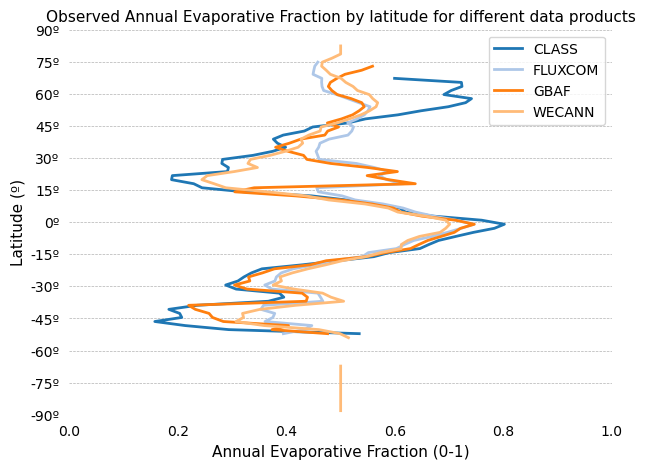

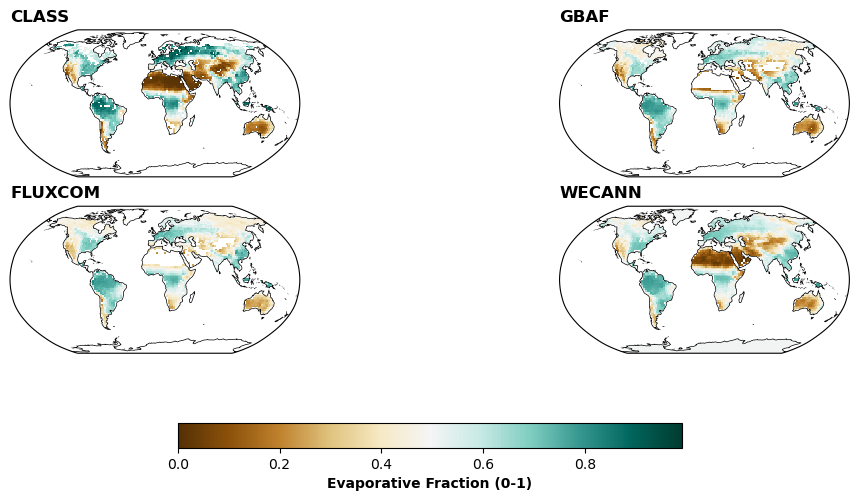

In [88]:
ef_glob, ef_bylat = get_by_lat(global_dat, 'ef', ef_models, '0-1')
plot_lat(ef_bylat, 'ef', 'Evaporative Fraction', '0-1')
plot_global(ef_glob, 'ef', 'Evaporative Fraction', '0-1', 'BrBG')

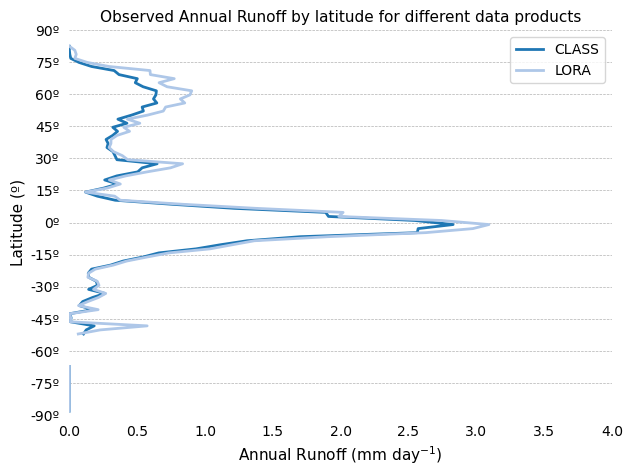

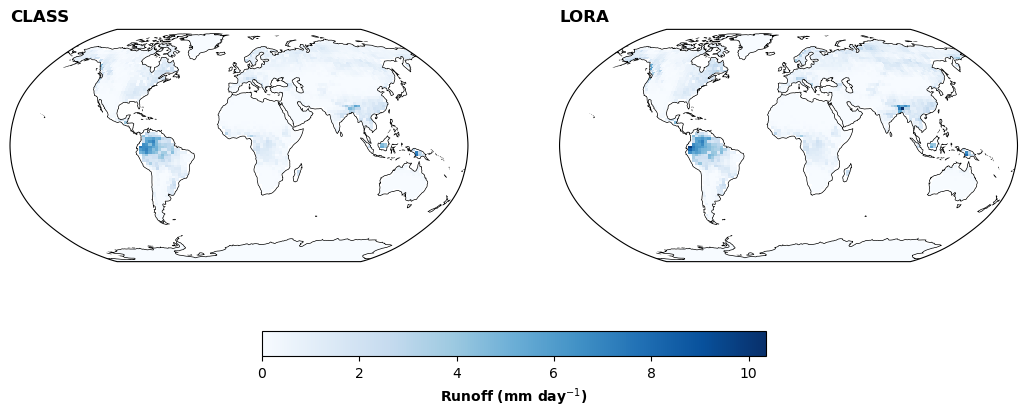

In [89]:
mrro_glob, mrro_bylat = get_by_lat(global_dat, 'mrro', mrro_models, 'mm day-1')
plot_lat(mrro_bylat, 'mrro', 'Runoff', 'mm day$^{-1}$')
plot_global(mrro_glob, 'mrro', 'Runoff', 'mm day$^{-1}$', 'Blues')

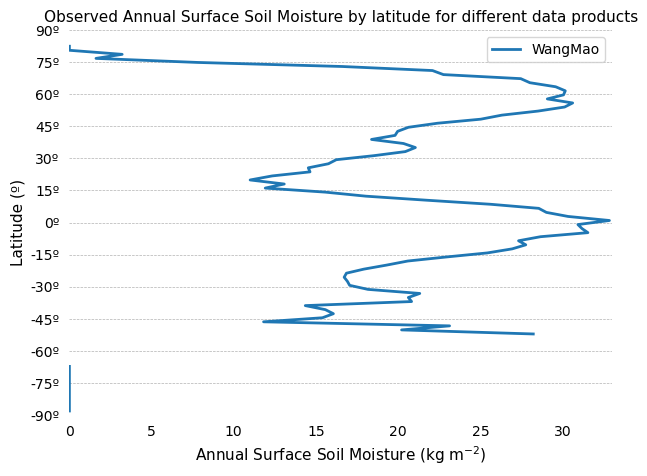

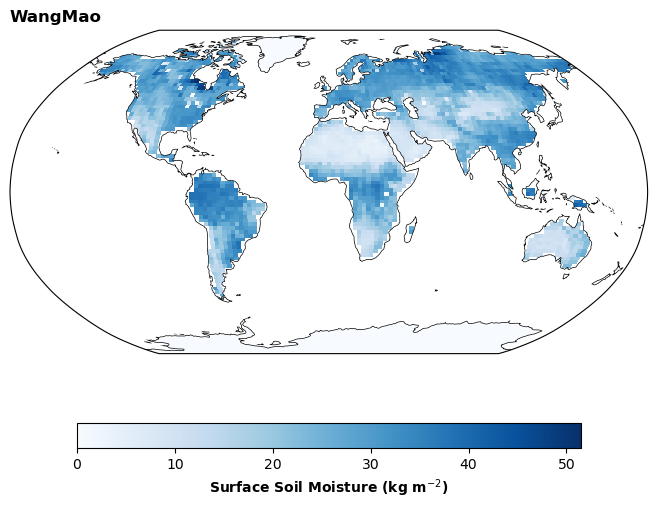

In [90]:
sw_glob, sw_bylat = get_by_lat(global_dat, 'sw', sw_models, 'kg m-2')
plot_lat(sw_bylat, 'sw', 'Surface Soil Moisture', 'kg m$^{-2}$')
plot_global(sw_glob, 'sw', 'Surface Soil Moisture', 'kg m$^{-2}$', 'Blues')

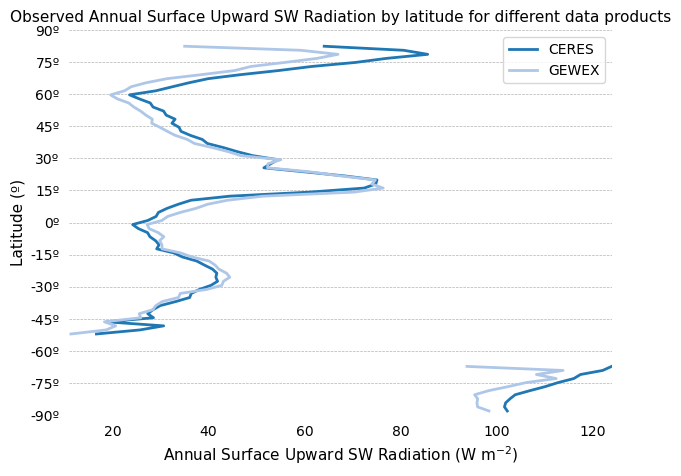

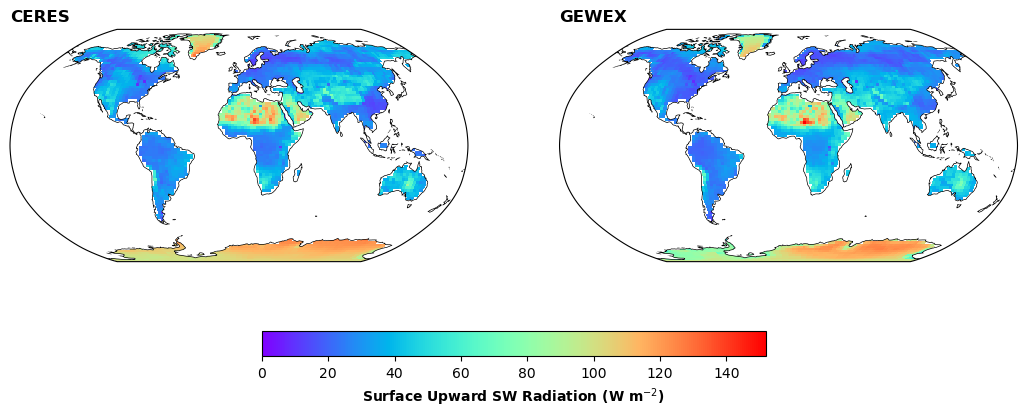

In [91]:
fsr_glob, fsr_bylat = get_by_lat(global_dat, 'fsr', fsr_models, 'W m-2')
plot_lat(fsr_bylat, 'fsr', 'Surface Upward SW Radiation', 'W m$^{-2}$')
plot_global(fsr_glob, 'fsr', 'Surface Upward SW Radiation', 'W m$^{-2}$', 'rainbow')

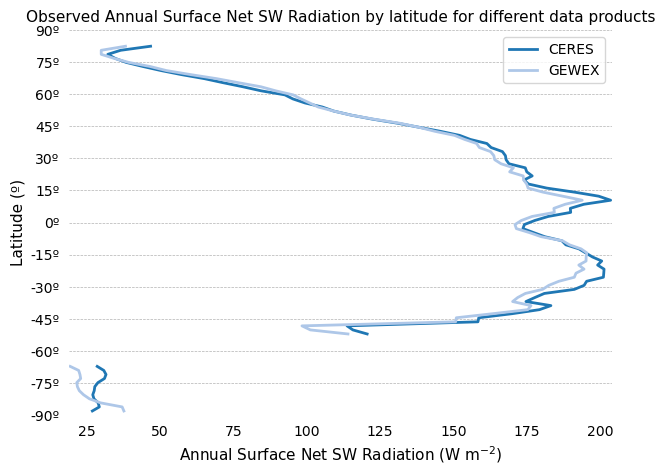

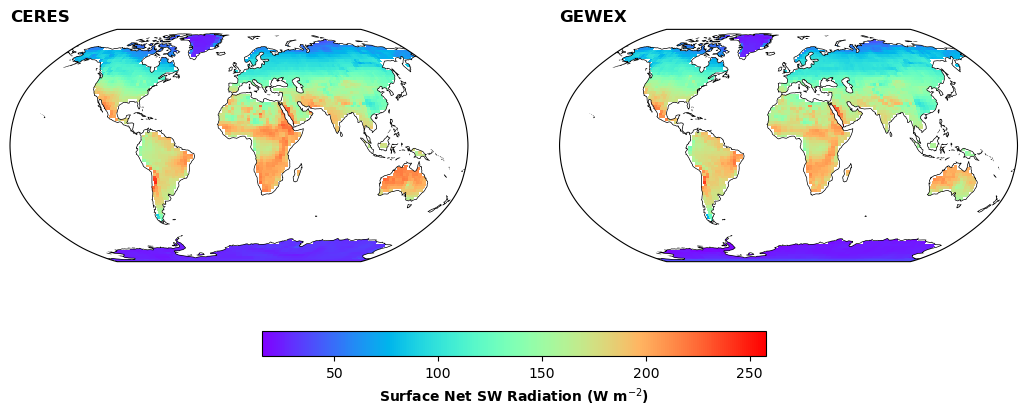

In [101]:
fsa_glob, fsa_bylat = get_by_lat(global_dat, 'fsa', fsa_models, 'W m-2')
plot_lat(fsa_bylat, 'fsa', 'Surface Net SW Radiation', 'W m$^{-2}$')
plot_global(fsa_glob, 'fsa', 'Surface Net SW Radiation', 'W m$^{-2}$', 'rainbow')

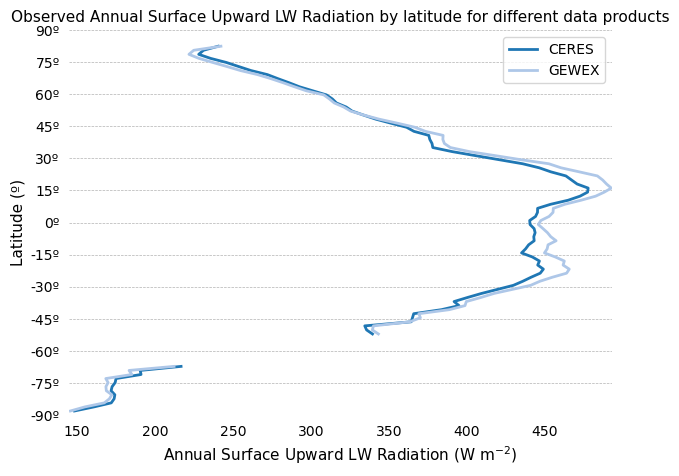

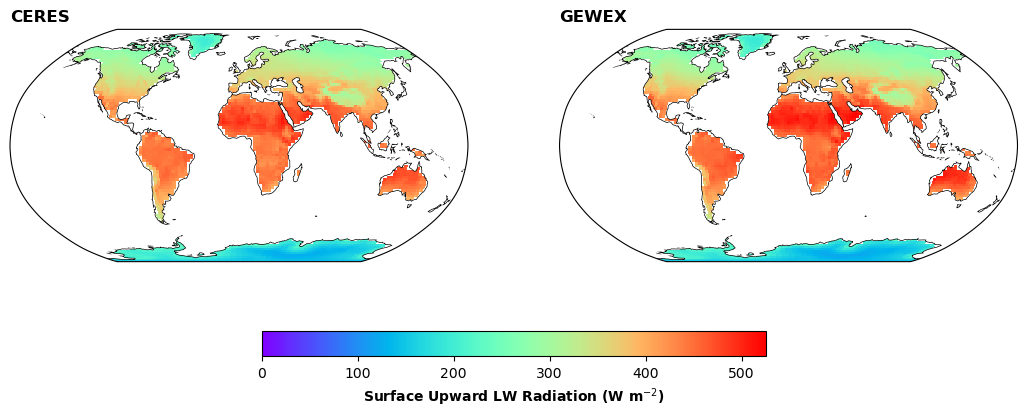

In [80]:
fire_glob, fire_bylat = get_by_lat(global_dat, 'fire', fire_models, 'W m-2')
plot_lat(fire_bylat, 'fire', 'Surface Upward LW Radiation', 'W m$^{-2}$')
plot_global(fire_glob, 'fire', 'Surface Upward LW Radiation', 'W m$^{-2}$', 'rainbow')

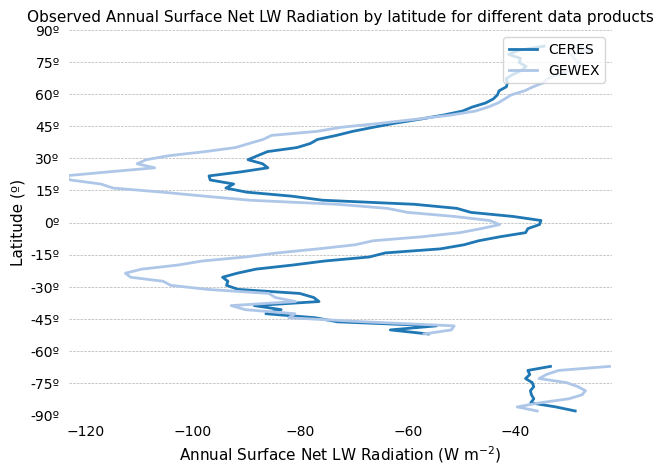

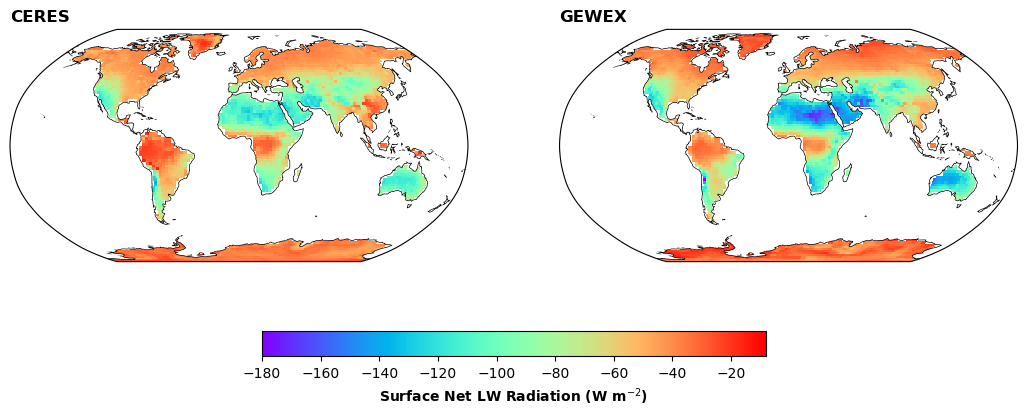

In [99]:
rlns_glob, rlns_bylat = get_by_lat(global_dat, 'rlns', rlns_models, 'W m-2')
plot_lat(rlns_bylat, 'rlns', 'Surface Net LW Radiation', 'W m$^{-2}$')
plot_global(rlns_glob, 'rlns', 'Surface Net LW Radiation', 'W m$^{-2}$', 'rainbow')

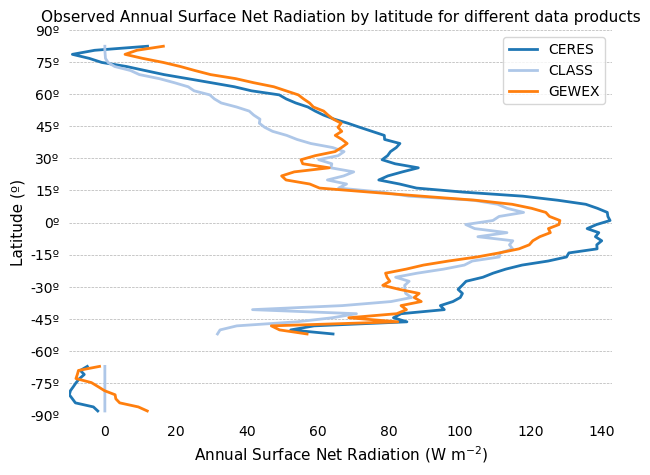

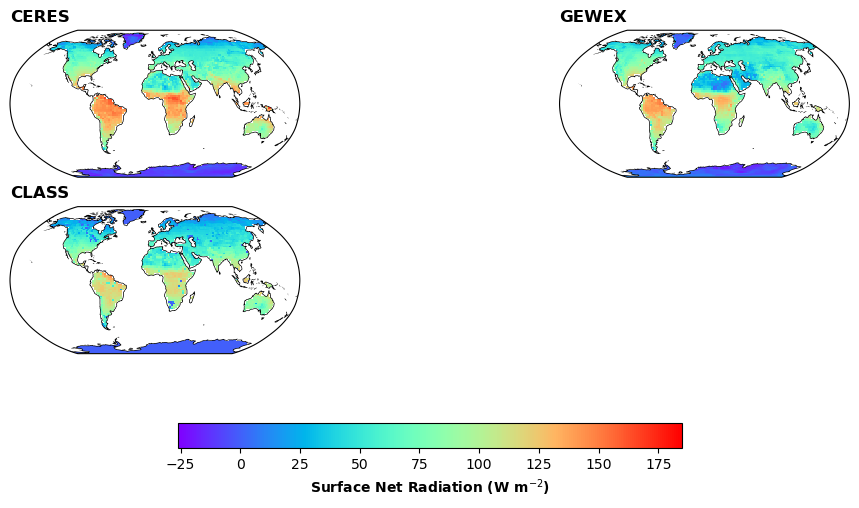

In [103]:
rn_glob, rn_bylat = get_by_lat(global_dat, 'rn', rn_models, 'W m-2')
plot_lat(rn_bylat, 'rn', 'Surface Net Radiation', 'W m$^{-2}$')
plot_global(rn_glob, 'rn', 'Surface Net Radiation', 'W m$^{-2}$', 'rainbow')

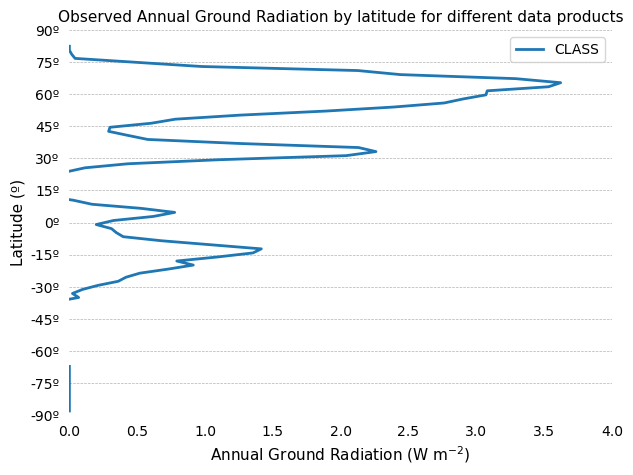

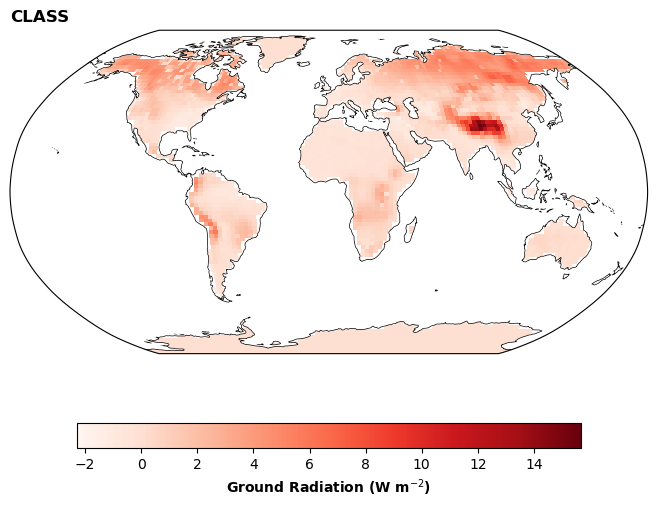

In [105]:
gr_glob, gr_bylat = get_by_lat(global_dat, 'gr', gr_models, 'W m-2')
plot_lat(gr_bylat, 'gr', 'Ground Radiation', 'W m$^{-2}$')
plot_global(gr_glob, 'gr', 'Ground Radiation', 'W m$^{-2}$', 'Reds')

## Calculate PFT Proportions and Dominance

In [114]:
fates_clm_ind = {"broadleaf_evergreen_tropical_tree": [4],
             "needleleaf_evergreen_extratrop_tree": [2, 1],
             "needleleaf_colddecid_extratrop_tree": [3],
             "broadleaf_evergreen_extratrop_tree": [5],
             "broadleaf_hydrodecid_tropical_tree": [6],
             "broadleaf_colddecid_extratrop_tree": [8, 7],
             "broadleaf_evergreen_extratrop_shrub": [9],
             "broadleaf_hydrodecid_extratrop_shrub": [11, 10],
             "broadleaf_colddecid_extratrop_shrub": [11, 10],
             "arctic_c3_grass": [12],
             "cool_c3_grass": [13],
             "c4_grass": [14]}

In [115]:
surdat_dir = "/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/"
surdat_2deg = os.path.join(surdat_dir, "release-clm5.0.18", "surfdata_1.9x2.5_hist_16pfts_Irrig_CMIP6_simyr2000_c190304.nc")
paramfile = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c211112.nc'

In [116]:
surdat = get_surdat(surdat_2deg)

In [117]:
params = xr.open_dataset(paramfile)
pftnames = [str(pftname).replace("b'", "").replace("'", "").strip() for pftname in params.pftname.values]

In [118]:
clm_pfts = pftnames[:17]
fates_pfts = list(fates_clm_ind.keys())

In [120]:
ds_biomeID = xr.open_dataset('../surfdata/biome_2deg.nc')

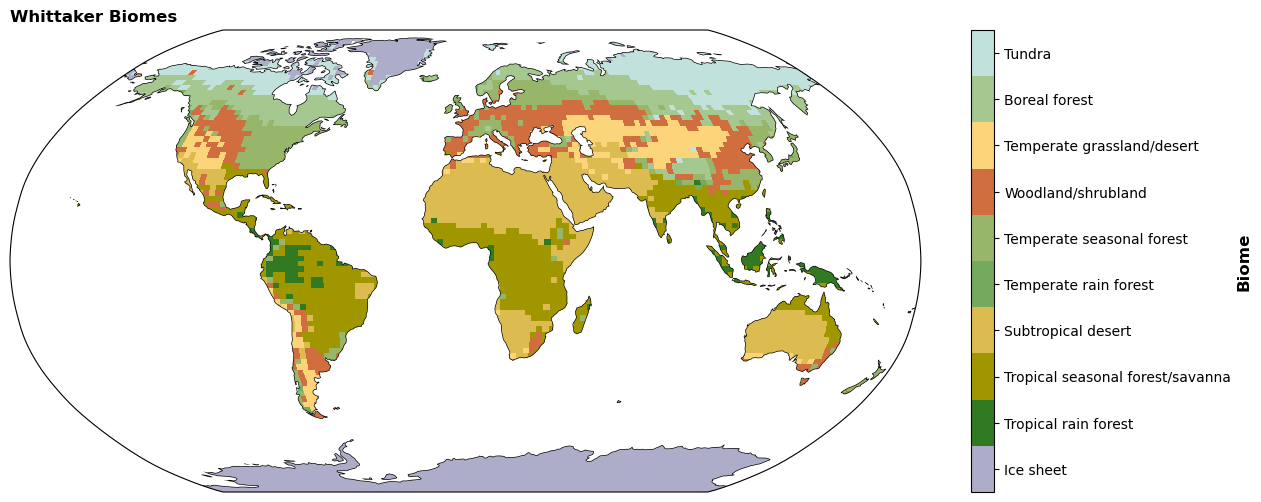

In [121]:
plot_biome(ds_biomeID)

In [122]:
ds_interp = surdat.interp(lat=ds_biomeID["lat"], lon=ds_biomeID["lon"])
surdat_biome = xr.merge([ds_interp, ds_biomeID])

In [ ]:
for pft in fates_pfts:
    pft_indices = fates_clm_ind[pft]
    gridcells, dompft = get_dom_pft_landmask(surdat_biome, pft_indices, 0)
    dompft = adjust_lon(dompft, 'lon')
    ds_interp = global_dat.interp(lat=dompft["lat"], lon=dompft["lon"])
    obs_dom = xr.merge([dompft, ds_interp])
    obs_dom = obs_dom.where(obs_dom.landmask == 1.0)
    obs_dom.to_netcdf(f"pft_biomes/{pft}_biome_presence.nc")

## Subset Surface Data to Sparse Grid

### Ensemble Information

In [ ]:
sg = xr.open_dataset('/glade/work/afoster/FATES_calibration/FATES_SP_LH/hist_500/ctsm51FATES_SP_OAAT_SatPhen_derecho_2000_FATES_LH_000.nc')
sg = sg.isel(time=0)

### Subset

In [ ]:
# Find absolute difference between requested point and the grid coordinates
lats = sg.grid1d_lat
lons = sg.grid1d_lon
lats_out = []
lons_out = []
i = 0
for a, o in zip(lats, lons):
    abslat = np.abs(surdat.lat - a)
    abslon = np.abs(surdat.lon - o)
    c = np.maximum(abslon, abslat)
    x, y = np.where(c == np.min(c))
    lats_out.append(y[0])
    lons_out.append(x[0])
lats_out = [int(lat) for lat in lats_out]
lons_out = [int(lon) for lon in lons_out]

In [ ]:
pft_grids = []
for i in range(len(lats_out)):
    sub = surdat_biome.isel(lat=lats_out[i]).isel(lon=lons_out[i])
    pct_nat_pft = sub.PCT_NAT_PFT_UPDATED.values
    pct_cf = sub.PCT_CFT_UPDATED.values
    pct_veg = np.append(pct_nat_pft, pct_cf)
    biome = sub.biome.values
    dat = {'pct_veg': pct_veg,
           'gridcell': np.repeat(i, len(pct_veg)),
           'pft': clm_pfts,
           'biome': np.repeat(biome, len(pct_veg))}
    df = pd.DataFrame(dat)
    pft_grids.append(df)
pft_dat = pd.concat(pft_grids)
pft_dat.to_csv('sparse_grid_pfts.csv')